In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


In [2]:
def baryfit_chebyshev(n):
    j = arange(n+1)
    w = (-1.)**j
    w[0] = w[0]*0.5
    w[-1] = w[-1]*0.5
    return w
def chebyshev_nodes(a, b, n):
    j = arange(n+1)
    return (a + b)/2 - (b - a)/2*cos(j*pi/n)
def baryeval(x, xnodes, ynodes, weights):
    n = xnodes.size - 1
    m = x.size
    numerator = zeros(m)
    denominator = zeros(m)
    for k in arange(m): ## loop over each evaluation point in `x`
        for j in arange(n+1): # j = 0, 1, ..., n
            if x[k] == xnodes[j]: # check if x = x_j
                numerator[k] = ynodes[j] ## p(x_j) = y_j
                denominator[k] = 1.
                break ## this will end the inner-most loop (skip to the next value of k)
            numerator[k] = numerator[k] + ynodes[j]*weights[j]/(x[k] - xnodes[j])
            denominator[k] = denominator[k] + weights[j]/(x[k] - xnodes[j])
    p_of_x = numerator/denominator
    return p_of_x

# The formula from the notes for the derivative matrix
\begin{align*}
      d_{ij} &= \frac{w_j}{w_i(x_i - x_j)}, \quad i\neq j \\
      d_{ii} &= - \sum_{\substack{k=0\\ k\neq i}}^{n+1} d_{ik}.
\end{align*}

In [3]:
n = 2
a = 0.
b = 10.

w = baryfit_chebyshev(n)
xnodes = chebyshev_nodes(a, b, n)

D = zeros((n+1, n+1))


# D[i, j] = w[j]/(w[i]*(xnodes[i] - xnodes[j]))

# i=0, j=1
D[0, 1] = w[1]/(w[0]*(xnodes[0] - xnodes[1]))
# i=0, j=2
D[0, 2] = w[2]/(w[0]*(xnodes[0] - xnodes[2]))

# i=1, j=0
D[1, 0] = w[0]/(w[1]*(xnodes[1] - xnodes[0]))
# i=1, j=2
D[1, 2] = w[2]/(w[1]*(xnodes[1] - xnodes[2]))

# i=2, j=0
D[2, 0] = w[0]/(w[2]*(xnodes[2] - xnodes[0]))
# i=2, j=1
D[2, 1] = w[1]/(w[2]*(xnodes[2] - xnodes[1]))

D[0, 0] = -D.sum(axis=1)[0]
D[1, 1] = -(D[1, 0] + D[1, 2])
D[2, 2] = -(D[2, 0] + D[2, 1])



# Let's use the derivative matrix to differentiate a 2nd degree polynomial
We will interpolate the function $f(x) = \sin(x)$ as an example.

In [4]:
def f(x):
    return sin(x)

ynodes = f(xnodes) ## call this polynomial q(x) (it is a 2nd degree polynomial because n=2)

dydxnodes = D@ynodes ## the y nodes for the new polynomial, the derivative of q(x)


## The derivative of a second degree polynomial is a first degree polynomial
Even though we are using $n=2$ (i.e., 3 x-nodes) to represent the derivative polynomial, it is actually only a 1st degree polynomial.

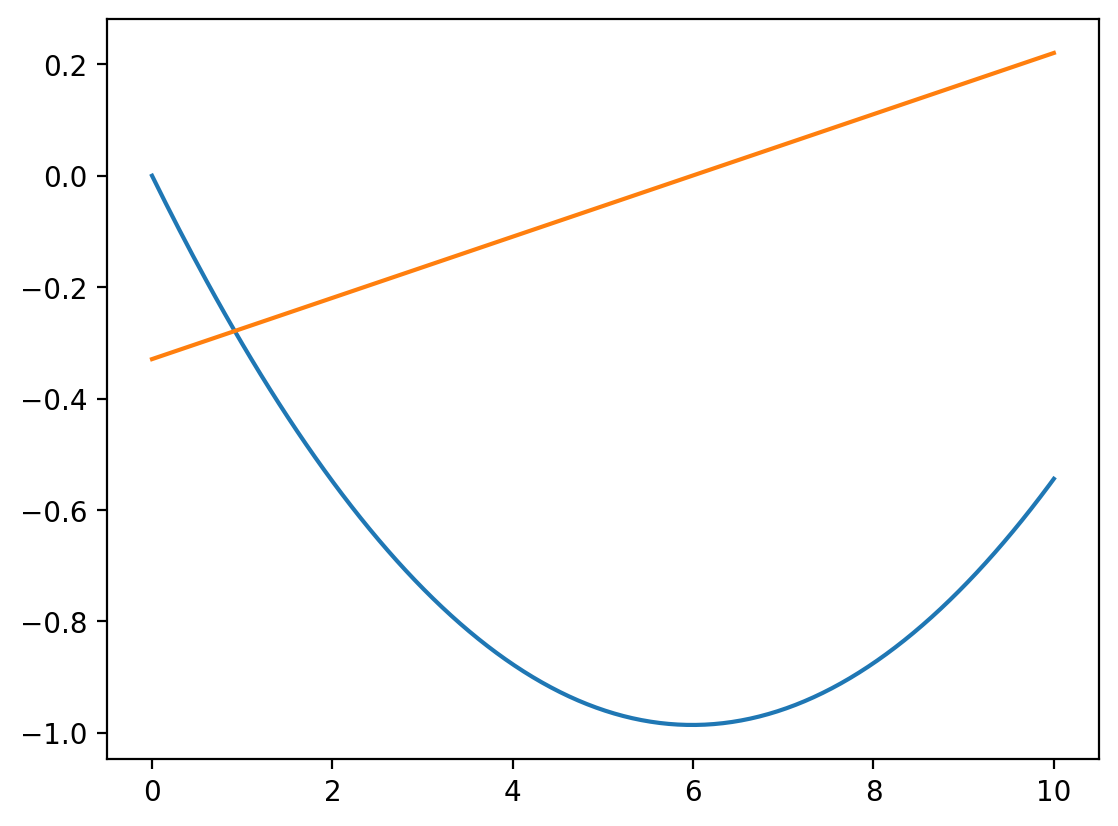

In [5]:
xeval = linspace(a, b, 200)
yeval = baryeval(xeval, xnodes, ynodes, w)
dydxeval = baryeval(xeval, xnodes, dydxnodes, w)

plot(xeval, yeval)
plot(xeval, dydxeval)
# plot(xeval, f(xeval)) # it is not a very good approximation because we only use 3 interpolation nodes

# Let's compute the indefinite integral of our 2nd degree polynomial
$$ p(x) = \int_a^x q(x')dx'  $$
$$ p(a) = \int_a^a q(x')dx'  = 0$$

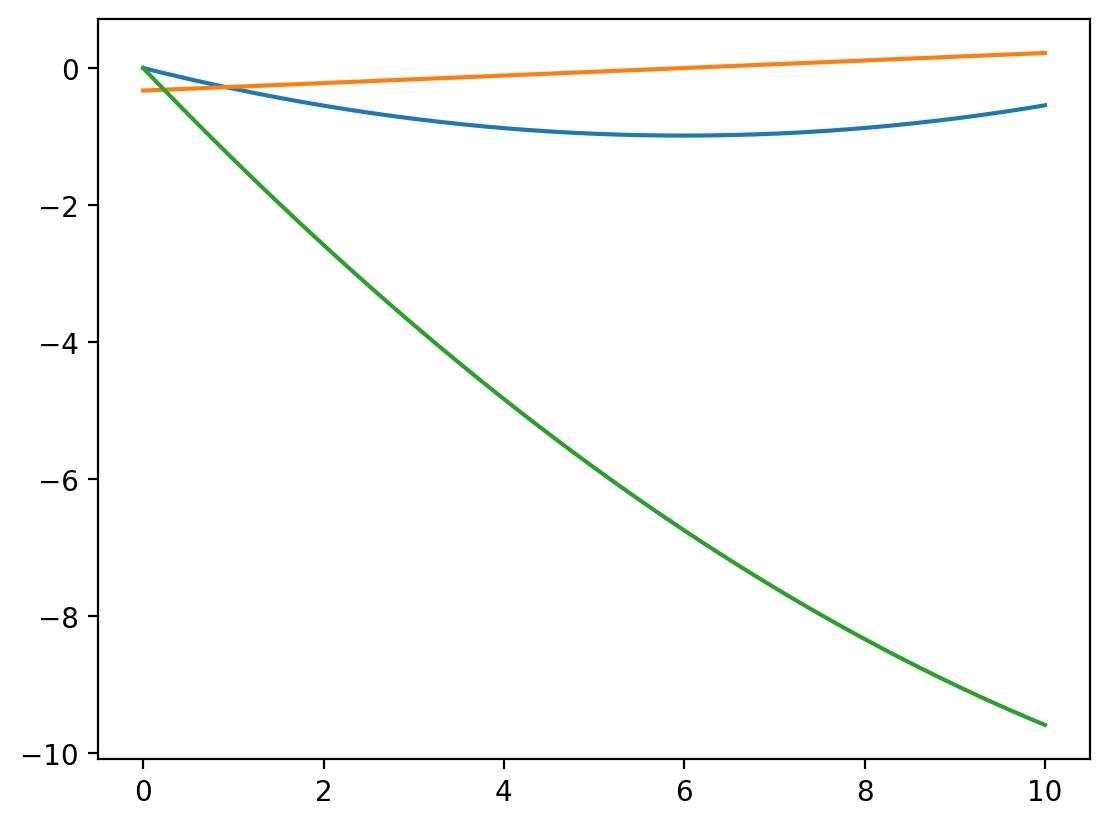

In [6]:
### D@yint_nodes = ynodes
Dhat = D.copy()


### yint_node[0] = 0
Dhat[0, 0] = 1.
Dhat[0, 1] = 0
Dhat[0, 2] = 0

rhs = ynodes.copy()
rhs[0] = 0.

yint_nodes = solve(Dhat, rhs)

yint_eval = baryeval(xeval, xnodes, yint_nodes, w)

plot(xeval, yeval)
plot(xeval, dydxeval)
plot(xeval, yint_eval)

# The above gives a polynomial of degree at most 2
The indefinite integral of our 2nd degree polynomial should be a 3rd degree polynomial (in general). If $n$ is large enough, the above is still a good approximation to the indefinite integral.
# How do we get the *exact* indefinite integral?
**We just need one more node.** We need to increase $n$ by one and change all three variables that define the polynomial interpolation of the indefinite integral.

In [7]:
wnew = baryfit_chebyshev(n+1)
xnew_nodes = chebyshev_nodes(a, b, n+1)

# construct the 4x4 derivative matrix (using loops)
D = zeros((n+2, n+2))
for i in arange(4):
    for j in arange(4):
        if i == j:
            continue ## skip over diagonal entries
        D[i, j] = wnew[j]/(wnew[i]*(xnew_nodes[i] - xnew_nodes[j]))
## do the diagonal terms
for i in arange(4):
    D[i, i] = -D[i, :].sum()
D

array([[-0.63333333,  0.8       , -0.26666667,  0.1       ],
       [-0.2       ,  0.06666667,  0.2       , -0.06666667],
       [ 0.06666667, -0.2       , -0.06666667,  0.2       ],
       [-0.1       ,  0.26666667, -0.8       ,  0.63333333]])

In [8]:
Dhat = D.copy()
## change the top row again, just as before
Dhat[0, 0] = 1.
Dhat[0, 1:] = 0.
Dhat

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-0.2       ,  0.06666667,  0.2       , -0.06666667],
       [ 0.06666667, -0.2       , -0.06666667,  0.2       ],
       [-0.1       ,  0.26666667, -0.8       ,  0.63333333]])

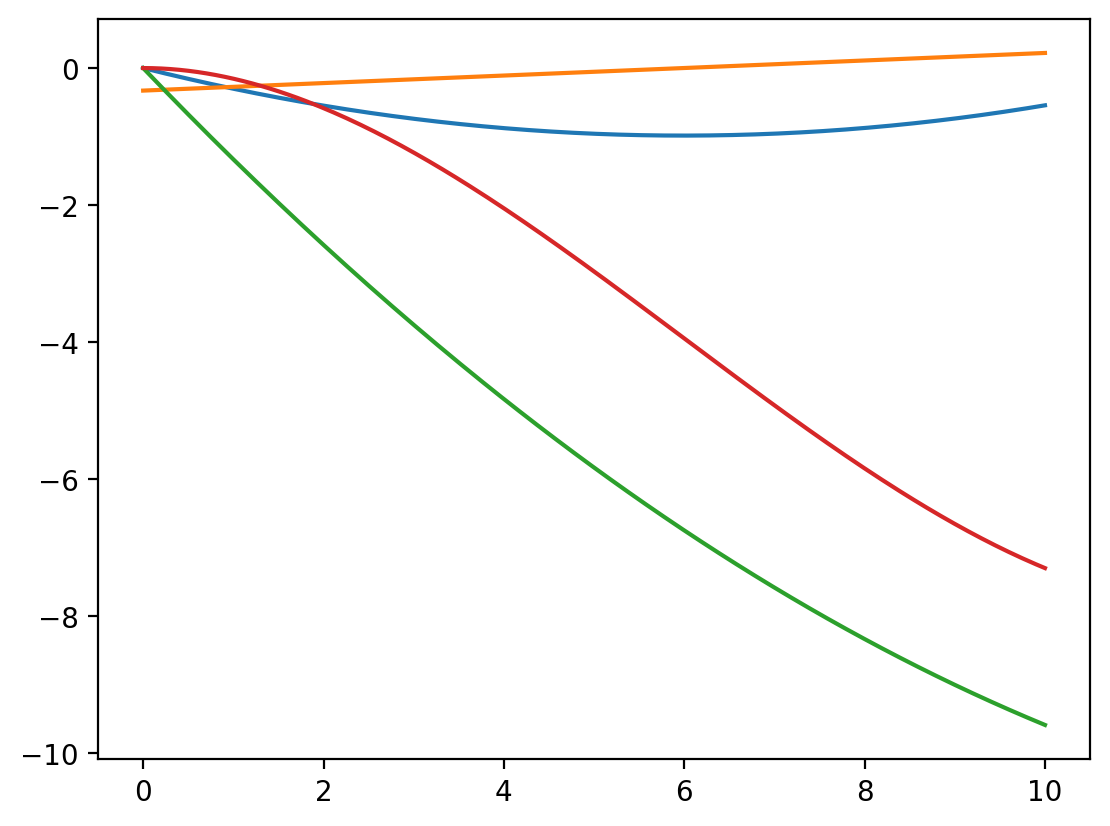

In [9]:
# We need to evaluate the polynomial we want to integrate at the new xnodes
rhs = baryeval(xnew_nodes, xnodes, ynodes, w) ## rhs = q(xnew_nodes)
rhs[0] = 0

yint_nodes = solve(Dhat, rhs)


ynew_int_eval = baryeval(xeval, xnew_nodes, yint_nodes, wnew)


plot(xeval, yeval)
plot(xeval, dydxeval)
plot(xeval, yint_eval)
plot(xeval, ynew_int_eval);

# Let's solve the following boundary value problem
$$ u''(x) = -1, \quad x \in (-1, 1) $$
$$ u(-1) = u(1) = 0 $$


In [10]:
n = 50
a = -1.
b = 1.
xnodes = chebyshev_nodes(a, b, n)
weights = baryfit_chebyshev(n)

D = zeros((n+1, n+1))

for i in arange(n+1):
    for j in arange(n+1):
        if i == j:
            continue
        D[i, j] = weights[j]/(weights[i]*(xnodes[i] - xnodes[j]))

for i in arange(n+1):
    D[i, i] = -D[i, :].sum()

D2 = D@D # make sure to use `@` instead of `*`

In [11]:
## Now we construct a linear system that represent the ODE.
## A@u = rhs represents the ODE D^2 u = -1, but also accounts for the boundary
## conditions
A = zeros((n+1, n+1))
A[1:-1, :] = D2[1:-1, :]
# the top and bottom row are changed to capture the boundary conditions
A[0, 0] = 1
A[-1, -1] = 1

rhs = -ones(n+1)
# the top and bottom elements of the right hand side are changed to capture the
# boundary conditions
rhs[0] = 0
rhs[-1] = 0

# the final step is to solve the linear system for u
u = solve(A, rhs)

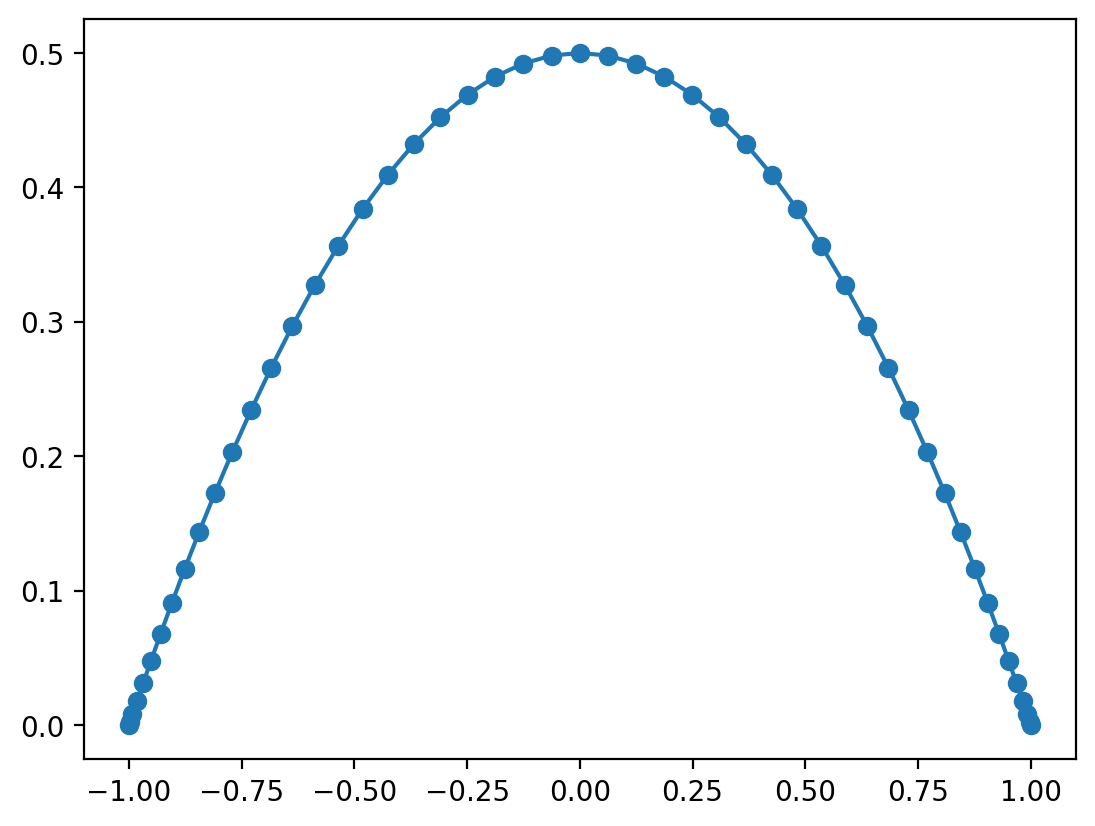

In [12]:
plot(xnodes, u, '-o')